In [1]:
import numpy as np
import matplotlib.pyplot as plt

#CT Radon transform forward model and denoising functions
from skimage.transform import radon, resize, iradon
from skimage.data import shepp_logan_phantom
from skimage.restoration import denoise_tv_chambolle

#MNIST dataset
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Deep inverse imports
import deepinv as dinv
from deepinv.models import DnCNN, DRUNet, UNet, AutoEncoder, epll, GSDRUNet, GSPnP

#TV and BM3D denoisers and tracker
from tqdm import tqdm
from bm3d import bm3d
from utils.torch_denoise_tv_chambolle import *

#local imports (Radon transform, Gaussian noise, FBP, PSNR and PnP-PGD, PnP-FISTA, PnP-ADMM algorithms and all the plotting functions)
from radon import forward_operator_radon, add_noise, fbp
from algorithms import *
from plotting import *

torch.manual_seed(42)
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([transforms.ToTensor()])



In [2]:
#For plots 
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2,
          "font.size": 20,
          "text.usetex": True,
          "font.family": "Computer Modern Roman",
          #"label.fontsize": 18
          }
plot.rcParams.update(params)

(-0.5, 27.5, 27.5, -0.5)

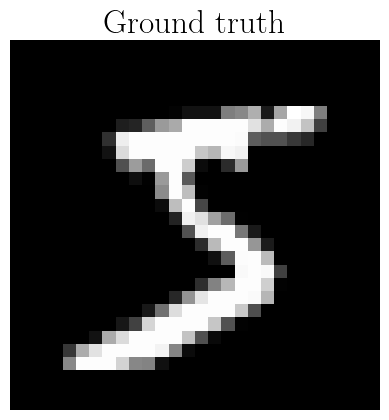

In [3]:
#MNIST digit 5 
mnist = MNIST(root='./data', train=True, download=True, transform=transform)
digit, label = mnist[0]
imsize = (28,28)
digit = digit.reshape(-1)
plt.title("Ground truth")
plt.imshow(digit.view(imsize), cmap = "gray")
plt.axis('off')

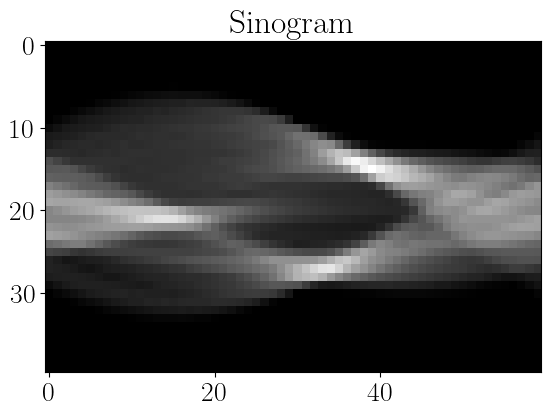

In [4]:
#Radon transform
n = 28
n_angles = 60

A = forward_operator_radon(n, n_angles)
#ground truth
x = digit.reshape(-1)



#y
y = np.reshape(A@x, (int(np.ceil(n*np.sqrt(2))), n_angles))
plt.title("Sinogram")
plt.imshow(y, cmap='gray')

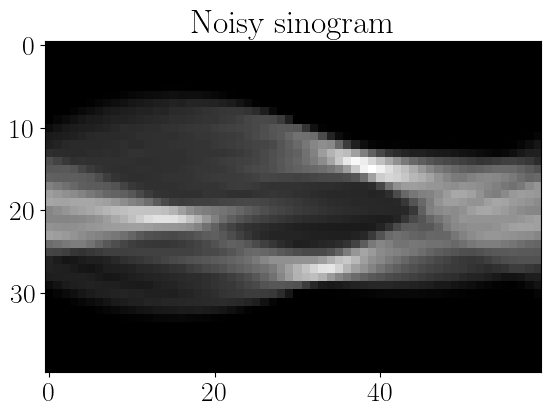

In [5]:
# Add Gaussian and Poisson noise to the sinogram
sigma = 0.01
gauss_y = add_noise(y, noise_type='gaussian', sigma = sigma)
poisson_y = add_noise(y, noise_type='poisson')
gy = add_noise(y, noise_type='gaussian', sigma = 0.002)
plt.title("Noisy sinogram")
plt.imshow(gauss_y.numpy(), cmap='gray')


Text(0.5, 1.0, 'Noise-free FBP reconstruction')

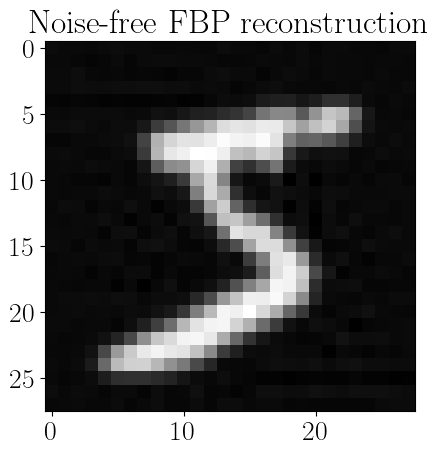

In [6]:
#Noise free FBP

reconstruction_fbp = fbp(y, n_angles)
plt.imshow(reconstruction_fbp, cmap='gray')
plt.title('Noise-free FBP reconstruction')


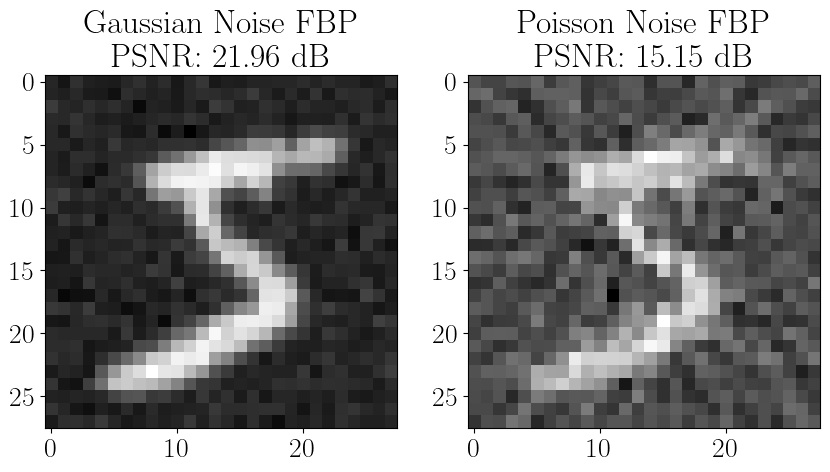

In [7]:
#Noisy reconstruction
s = 0.05
gfbp = fbp(gauss_y, n_angles)
gf = fbp(gy, n_angles)
pfbp = fbp(poisson_y, n_angles)
gfbp =  gfbp.reshape(n, n) + torch.randn(n,n)*s
g_psnr = PSNR(x, gfbp)
p_psnr = PSNR(x, pfbp)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f"Gaussian Noise FBP \n PSNR: {g_psnr:.2f} dB")
plt.imshow(gfbp, cmap='gray')

plt.subplot(1, 2, 2)
plt.title(f"Poisson Noise FBP \n PSNR: {p_psnr:.2f} dB")
plt.imshow(pfbp, cmap='gray')

# Optimisation algorithms (PGD and ADMM) for reconstruction (priors)

In [8]:
from tqdm import tqdm
from bm3d import bm3d
from utils.torch_denoise_tv_chambolle import *

In [9]:
#Deep denoisers
channels = 1
# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)


In [10]:
#Deep denoisers
channels = 1
# DnCNN Zhang 2017 denoiser
dncnn = DnCNN(
    in_channels=channels,
    out_channels=channels,
    pretrained="download",  
    device="cpu",
)

# Zhang 2021 denoiser
drunet = DRUNet(
    in_channels= channels,
    out_channels= channels,
    pretrained="download",
    device="cpu",
)


# GS-DRUNet denoiser
gsdrunet = GSDRUNet(
    in_channels= 1,
    out_channels= 1,
    pretrained="download",
    device="cpu",
)



In [11]:
H = A.T @ A
ev = power_method(H)
print(f"Largest eigenvalue estimate: {ev}")

Largest eigenvalue estimate: 1620.8892822265625


# PnP-PGD for the five denoisers (TV, BM3D, DnCNN, DRUNet, GSDRUNet)
# Imported via from algorithms.py




In [ ]:
lamb = 1e-4
best = 0
for lamb in [1e-5, 1e-4, 1e-3, 1, 1e+1]:
    tv, r1, d1, tvpairs, tincr = pnp_fista(A, gauss_y, x, method = 'tv', reg_l = lamb, iters = 500)
    if r1[-1] >= best:
        best = r1[-1]
        b_lamb = lamb

print("Best lambda:", b_lamb)
#plt.imshow(prox.reshape(imsize), cmap = 'gray')

# PnP-PGD results

In [17]:
from algorithms import pnp_pgd
#tv
x_tv, tvr, tvdiff, tvpairs, tvincr = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 1e-5, iters = 200)
#plt.imshow(x_tv.reshape(imsize), cmap = 'gray')

tv-PnP PGD iterations: 100%|██████████| 200/200 [00:00<00:00, 650.66it/s]

PnP-tv Final PSNR: 31.09 dB


In [18]:
#x_tv, tvr, tvdiff, tvpairs, tvincr = pnp_fista(A, gauss_y, x, 'tv', reg_l = 1e-4, iters = 200)
#plt.imshow(x_tv.reshape(imsize), cmap = 'gray')

In [1252]:
#bm3d
#x_bm3d, bm3dr, bm3diff, bm3dpairs, bm3dincr = pnp_fista(A, gauss_y, x, method = 'bm3d', reg_l = 1e-5, iters = 200)
x_bm3d, bm3dr, bm3diff, bm3dpairs, bm3dincr = pnp_pgd(A, gauss_y, x, method = 'bm3d', reg_l = 1e-5, iters = 200)

bm3d-PnP PGD iterations:  92%|█████████▏| 183/200 [08:10<00:46,  2.73s/it]

bm3d-PnP PGD iterations:  92%|█████████▏| 184/200 [08:12<00:41,  2.60s/it]

bm3d-PnP PGD iterations:  92%|█████████▎| 185/200 [08:14<00:34,  2.33s/it]

bm3d-PnP PGD iterations:  93%|█████████▎| 186/200 [08:15<00:29,  2.14s/it]

bm3d-PnP PGD iterations:  94%|█████████▎| 187/200 [08:17<00:28,  2.18s/it]

bm3d-PnP PGD iterations:  94%|█████████▍| 188/200 [08:20<00:27,  2.32s/it]

bm3d-PnP PGD iterations:  94%|█████████▍| 189/200 [08:23<00:28,  2.55s/it]

bm3d-PnP PGD iterations:  95%|█████████▌| 190/200 [08:26<00:24,  2.48s/it]

bm3d-PnP PGD iterations:  96%|█████████▌| 191/200 [08:28<00:23,  2.61s/it]

bm3d-PnP PGD iterations:  96%|█████████▌| 192/200 [08:32<00:22,  2.84s/it]

bm3d-PnP PGD iterations:  96%|█████████▋| 193/200 [08:35<00:19,  2.80s/it]

bm3d-PnP PGD iterations:  97%|█████████▋| 194/200 [08:37<00:15,  2.65s/it]

bm3d-PnP PGD iterations:  98%|█████████▊| 195/200 [08:39<00:12,  2.60s/it]

bm3d-PnP PGD iterations:  98%|█████████▊| 196/200 [08:42<00:10,  2.51s/it]

bm3d-PnP PGD iterations:  98%|█████████▊| 197/200 [08:44<00:07,  2.57s/it]

bm3d-PnP PGD iterations:  99%|█████████▉| 198/200 [08:46<00:04,  2.43s/it]

bm3d-PnP PGD iterations: 100%|█████████▉| 199/200 [08:49<00:02,  2.40s/it]

bm3d-PnP PGD iterations: 100%|██████████| 200/200 [08:51<00:00,  2.66s/it]

Final PSNR: 17.31 dB


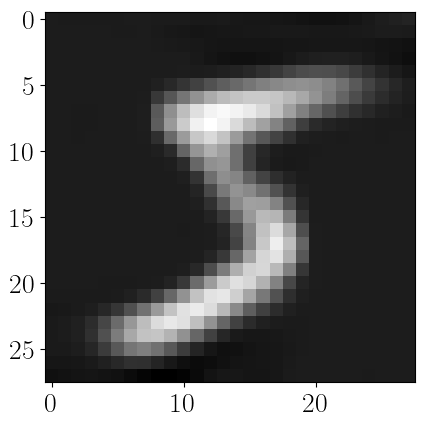

In [1253]:
plt.imshow(x_bm3d.reshape(imsize), cmap='gray')

In [23]:
#deep denoisers (DnCNN and DRUNet)
x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = 200)
a, b, c, d, e = pnp_pgd(A, gauss_y, x, method = 'tv', reg_l = 1e-4, iters = 78)
x_dncnn = a
#plt.imshow(x_dncnn.reshape(n,n), cmap='gray')

DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 82.68it/s]


PnP-DnCNN Final PSNR: 28.52 dB


tv-PnP PGD iterations: 100%|██████████| 78/78 [00:00<00:00, 629.89it/s]

PnP-tv Final PSNR: 28.55 dB


In [957]:
p = 0
bl = 0
for l in [850, 870,  900, 950]:
    x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = 200, L= l)
    if drur[-1] >= p:
        p = drur[-1]
        bl = l 

print("Best PSNR:", p, " with best stepsize:", bl)

DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 93.84it/s] 


Final PSNR: 30.66 dB


DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 91.53it/s]


Final PSNR: 30.59 dB


DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 81.94it/s]


Final PSNR: 30.48 dB


DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 83.81it/s]

Final PSNR: 30.30 dB
Best PSNR: tensor(30.6624)  with best stepsize: 850


In [12]:
#deep denoisers
it = 200
#x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_admm(A, gauss_y, x, method = 'DnCNN', niter = it)
#x_drunet, drur, drudiff, drupairs, druincr = pnp_admm(A, gauss_y, x, method = 'DRUNet', niter = it)
x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = it, reg_l= 100,  L = 850)
x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = it, L = 750)
x_gsdrunet, gsdrur, gsdrudiff, gsdrupairs, gsdruincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = it, L = 800)

DnCNN-PnP PGD iterations: 100%|██████████| 200/200 [00:02<00:00, 76.60it/s]


PnP-DnCNN Final PSNR: 30.98 dB


DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [00:16<00:00, 12.44it/s]


PnP-DRUNet Final PSNR: 22.21 dB


GS-DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [00:22<00:00,  8.87it/s]

PnP-GS-DRUNet Final PSNR: 23.45 dB


In [13]:
x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = it, L = 750)

DRUNet-PnP PGD iterations: 100%|██████████| 200/200 [00:14<00:00, 13.91it/s]

PnP-DRUNet Final PSNR: 22.21 dB


In [ ]:
x_dncnn, cnnr, cnndiff, cnnpairs, cnnincr = pnp_pgd(A, gauss_y, x, method = 'DnCNN', iters = it)
x_drunet, drur, drudiff, drupairs, druincr = pnp_pgd(A, gauss_y, x, method = 'DRUNet', iters = it)
x_gsdrunet, gsdrur, gsdrudiff, gsdrupairs, gsdruincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = it)

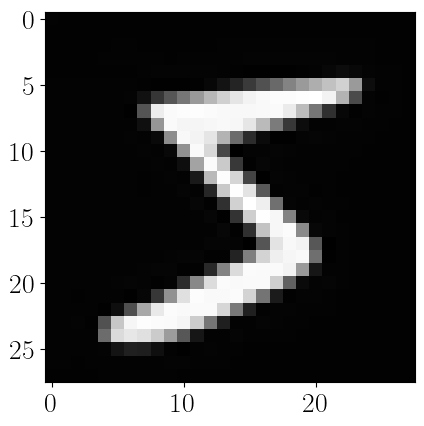

In [14]:
plt.imshow(x_drunet.reshape(imsize), cmap='gray')

In [931]:
x_gsdrunet, gsdrur, gsdrudiff, gsdrupairs, gsdruincr = pnp_pgd(A, gauss_y, x, method = 'GS-DRUNet', iters = 500)

GS-DRUNet-PnP PGD iterations: 100%|██████████| 500/500 [00:55<00:00,  8.94it/s]

Final PSNR: 20.74 dB


In [950]:
xvals =np.arange(1, 201)
yvals = 1/xvals

In [15]:
#comparison_plot(proxr,'Proximal', color='orange')
comparison_plot(tvr, 'TV', color='blue')
comparison_plot(bm3dr, 'BM3D', color='red')
comparison_plot(cnnr, 'DnCNN', color='purple')
comparison_plot(drur, 'DRUNet', color='green')
comparison_plot(gsdrur, 'GS-DRUNet', color='pink')


NameError: name 'tvr' is not defined

# Noise distribution between iterates for the denoisers $(D(x^{(k)}) - x^{(k)})$

In [310]:
import pylab as plot
params = {'legend.fontsize': 15,
          'legend.handlelength': 2,
          "font.size": 20,
          "text.usetex": True,
          "font.family": "Computer Modern Roman",
          #"label.fontsize": 18
          }
plot.rcParams.update(params)

In [752]:
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import kstest, cramervonmises, norm, ecdf
def pdf_plot(noise_diff, iterates_pairs, iteration, title):
    """
    Plotting the differences between inverted and denoised iterates of x^(k)
    """
    fontsize = 20
    fig1, axs = plt.subplots(1, 3, figsize=(12, 4))
    noised_x = iterates_pairs[iteration][0].reshape(imsize)
    denoised_x = iterates_pairs[iteration][1].reshape(imsize)
    fig1.suptitle(title + str(iteration + 1), fontsize = fontsize)
    axs[0].imshow(noised_x, cmap = 'gray')
    axs[1].imshow(denoised_x, cmap = 'gray')
    axs[2].imshow(noise_diff.reshape(imsize), cmap = 'gray')

    axs[0].set_title('Inverted iterate', fontsize = fontsize)
    axs[1].set_title('Denoised iterate', fontsize = fontsize)
    axs[2].set_title('$x^{(k)} - D_{\\sigma}(x^{(k)})$', fontsize = fontsize)
    plt.tight_layout()
    axs[0].axis('off')
    axs[1].axis('off')
    axs[2].axis('off')
    plt.show()

    #Normalising the pixel values
    noise_diff = (noise_diff - torch.min(noise_diff))/(torch.max(noise_diff) - torch.min(noise_diff))
    #noise_diff = (noise_diff - torch.mean(noise_diff))/(torch.std(noise_diff))
    noise_diff_np = noise_diff.numpy().flatten()
    iterate = title + str(iteration+1)

    #Reference gaussian pdf with same mean and standard deviation
    xrange = np.linspace(0, 1, 1000)
    mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
    gaussian_pdf = norm.pdf(xrange, loc=mu, scale=std)
    

    #Compute kernel density estimate (kde for pdf of noise distribution)
    fig2 = plt.figure(figsize=(8,6))
    kde = sm.nonparametric.KDEUnivariate(noise_diff) 
    kde.fit()

    peak_index = np.argmax(kde.density)
    peak_value = kde.support[peak_index]
    # Set the range around the peak
    x_range = kde.support[(kde.support >= peak_value - 2) & (kde.support <= peak_value + 2)]
    
    #fig = plt.figure(layout="constrained", figsize=(12, 5))
    plt.hist(noise_diff, density = True, bins = 80, alpha = 0.5, color="#D58817", label = 'Histogram frequency')
    plt.plot(kde.support, kde.density, color="#5AB4DC", label = 'Kernel density estimate PDF (KDE)')
    plt.plot(xrange, gaussian_pdf, label='Gaussian PDF', color='red', linestyle='--')
    #sns.kdeplot(noise_diff.numpy(), fill = True, color='g')

    plt.xlim([0.001, 1.001])
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Density')
    plt.title(iterate + " \n PDF of pixel intensities for $x^{(k)} - D_{\\sigma}(x^{(k)})$", fontsize = fontsize)
    plt.grid(True)
    plt.legend()
    
    plt.show()
    
    
    D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
    print(f'KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')
    
    if p_value > 0.05:
        print("The residual noise appears to follow a Gaussian distribution (accept H0)")
    else:
        print("The residual noise does not appear to follow a Gaussian distribution (reject H0)")
        
    


In [757]:
"""
r = gauss_y - y
noise_diff_np = r.numpy().flatten()
ncdf = norm.cdf(np.linspace(-3, 3, len(noise_diff_np)))

normalized_gaussian = norm.cdf(np.linspace(-3, 3, len(noise_diff_np))) 
#ks test
mu, std = np.mean(noise_diff_np), np.std(noise_diff_np)
D, p_value = kstest(noise_diff_np, 'norm', args=(mu, std))
print(f'KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')
"""

KS Test: D-statistic=0.0141, p-value=0.7246


In [ ]:
shift = 0
iterates = [0, 5, 15, 199] 
for i in [49, 99, 149, 199]:
    #pdf_plot(proxdiff[i+shift], proxpairs, iteration = i+shift, title = "Prox iterate: $k=$ ")
    pdf_plot(atvdiff[i+shift], atvpairs, iteration = i+shift, title = "TV iterate: $k=$ ")
    #pdf_plot(acnndiff[i+shift], adncnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$ ")
    #pdf_plot(adrudiff[i+shift], adrupairs, iteration = i+shift, title = "DRUNet iterate: $k=$ ")
    #pdf_plot(gsdrudiff[i+shift], agsdrupairs, iteration = i+shift, title = "GS-DRUNet iterate: $k=$ ")
    #pdf_plot(abm3diff[i], abm3dpairs, iteration = i, title = "BM3D iterate: $k=$ ")

In [ ]:
shift = 0
iterates = [0, 199] 
for i in iterates:
    #pdf_plot(proxdiff[i+shift], proxpairs, iteration = i+shift, title = "Prox iterate: $k=$")
    pdf_plot(tvdiff[i+shift], tvpairs, iteration = i+shift, title = "TV iterate: $k=$")
    #pdf_plot(cnndiff[i+shift], cnnpairs, iteration = i+shift, title = "DnCNN iterate: $k=$")
    #pdf_plot(drudiff[i+shift], drupairs, iteration = i+shift, title = "DRUNet iterate: $k=$")
    #pdf_plot(gsdrudiff[i+shift], gsdrupairs, iteration = i+shift, title = "GS-DRUNet iterate: $k=$")
    pdf_plot(bm3diff[i], bm3dpairs, iteration = i, title = "BM3D iterate: $k=$")

In [715]:
D, p_value = kstest(np.random.normal(0,1, 100), 'norm', args=(0, 1))
print(f'KS Test: D-statistic={D:.4f}, p-value={p_value:.4f}')

KS Test: D-statistic=0.1095, p-value=0.1684


In [ ]:
pdf_plot(gfbp.flatten() - x, [[gfbp.flatten(), x]], iteration = 0, title = "Orignal vs noisy sinogram")

<>:18: SyntaxWarning: invalid escape sequence '\|'
<>:36: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\|'
<>:36: SyntaxWarning: invalid escape sequence '\s'
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\2412466885.py:18: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\2412466885.py:36: SyntaxWarning: invalid escape sequence '\s'
  ax2.semilogy(iterations, 12/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\2412466885.py:36: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogy(iterations, 12/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)


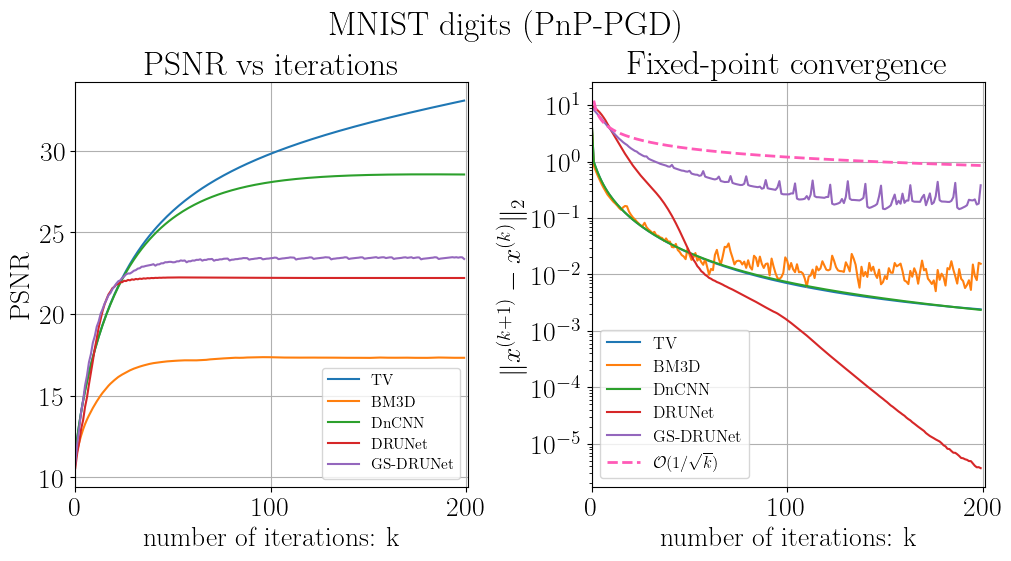

In [1162]:
#Main plotting and reconstruction functions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('MNIST digits (PnP-PGD)')
ax1.set_title('PSNR vs iterations')
ax2.set_title('Fixed-point convergence')
def plot_psnrs_differences(psnrs, diffs, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    #fig.suptitle(method)
    ax1.plot(range(0, len(psnrs)), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(range(0, len(diffs)),diffs, label = method)
    ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    ax1.set_xlim([0, 201])
    ax2.set_xlim([0, 201])
    return psnrs[-1]


#p1 = plot_psnrs_differences(proxr, proxincr, 'Prox')
t1 = plot_psnrs_differences(tvr, tvincr, 'TV')
b1 = plot_psnrs_differences(bm3dr, bm3dincr, 'BM3D')
d1 = plot_psnrs_differences(cnnr, cnnincr, 'DnCNN')
dr1 = plot_psnrs_differences(drur, druincr, 'DRUNet')
gs1 = plot_psnrs_differences(gsdrur, gsdruincr, 'GS-DRUNet')

iterations = np.arange(200)

#ax2.semilogy(iterations, 80/iterations, label = '$\\mathcal{O}(1/k)$', linestyle = '--', color = '#13A49F', linewidth = 2)
ax2.semilogy(iterations, 12/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)

psnrs_list = [PSNR(x, gfbp), t1, b1, d1, dr1, gs1]

ax1.legend(fontsize = 11, loc = 'lower right')
ax2.legend(fontsize = 12)

plt.savefig('plots/PnPPGDGraphs.png', dpi = 300)


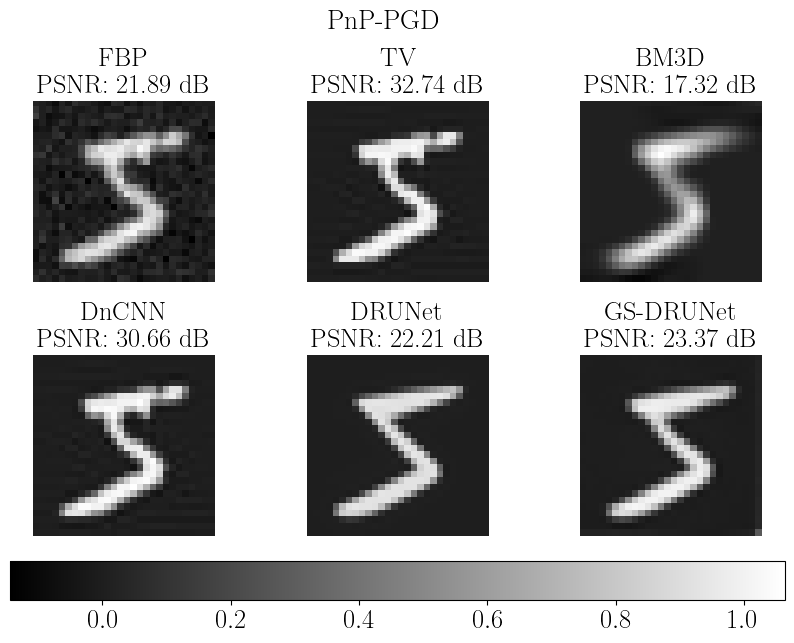

In [1112]:
def plotting_estimates1(fbp, x1, x2, x3, x4, x5, psnrs_list, title):
    size = 19
    fig, axs = plt.subplots(2, 3, figsize=(10, 6.5))
    fig.subplots_adjust(hspace=0.4)
    fig.suptitle(title, size = 20, y = 1.02)

    vmin = min(fbp.min(), x1.min(), x2.min(), x3.min(), x4.min(), x5.min())
    vmax = max(fbp.max(), x1.max(), x2.max(), x3.max(), x4.max(), x5.max())

    # Plotting the images
    im0 = axs[0, 0].imshow(fbp, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0, 0].set_title(f"FBP \n PSNR: {psnrs_list[0]:.2f} dB", fontsize=size)
    axs[0, 1].imshow(x1, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0, 1].set_title(f'TV \n PSNR: {psnrs_list[1]:.2f} dB', fontsize=size)
    axs[0, 2].imshow(x2, cmap='gray', vmin=vmin, vmax=vmax)
    axs[0, 2].set_title(f'BM3D \n PSNR: {psnrs_list[2]:.2f} dB', fontsize=size)
    axs[1, 0].imshow(x3, cmap='gray', vmin=vmin, vmax=vmax)
    axs[1, 0].set_title(f'DnCNN \n PSNR: {psnrs_list[3]:.2f} dB', fontsize=size)
    axs[1, 1].imshow(x4, cmap='gray', vmin=vmin, vmax=vmax)
    axs[1, 1].set_title(f'DRUNet \n PSNR: {psnrs_list[4]:.2f} dB', fontsize=size)
    axs[1, 2].imshow(x5, cmap='gray', vmin=vmin, vmax=vmax)
    axs[1, 2].set_title(f'GS-DRUNet \n PSNR: {psnrs_list[5]:.2f} dB', fontsize=size)

    # Adding a color bar for the whole figure
    cbar = fig.colorbar(im0, ax=axs, orientation='horizontal', fraction=0.08, pad=0.05)
    cbar.ax.tick_params(labelsize=size)
    for i in range(2):
        for j in range(3):
            axs[i, j].axis('off')

imsize = (n, n)

plotting_estimates1(gfbp.reshape(imsize), x_tv.reshape(imsize), x_bm3d.reshape(imsize), x_dncnn.reshape(imsize), x_drunet.reshape(imsize), x_gsdrunet.reshape(imsize), psnrs_list, title = "PnP-PGD")

tv-PnP ADMM iterations: 100%|██████████| 30/30 [00:00<00:00, 226.47it/s]


Final PSNR: 24.30 dB


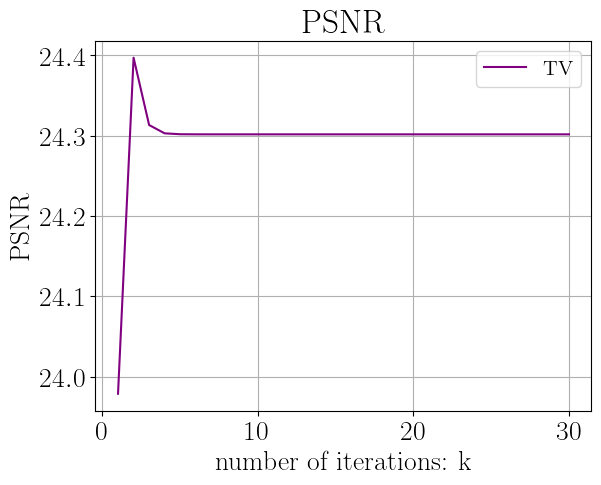

In [19]:
atv, atvp, atvd, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = 30, lamb = 1e-3, beta = 10)
comparison_plot(atvp, 'TV', color='purple')

In [1124]:
aprox, aproxpnsr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = 50, lamb = 1e-4)

proximal-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 317.09it/s]

Final PSNR: 24.31 dB


In [762]:
lambs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
betas = [1e+1, 1e+2]
best = 0
b_lamb, b_beta = 0, 0
for l in lambs:
    for beta in betas:
        atv, atvp, atvd, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = 50, lamb = l)
        if atvp[-1] > best:
            best = atvp[-1]
            b_lamb, b_beta = lamb, beta

print("Best beta:", b_beta, "\n Best lambda:", b_lamb)
beta = 1e+1
lamb = 1


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 161.37it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 227.78it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 249.58it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 248.44it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 196.80it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 207.38it/s]


Final PSNR: 22.45 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 144.38it/s]


Final PSNR: 22.47 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 174.13it/s]


Final PSNR: 22.47 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 98.12it/s] 


Final PSNR: 22.65 dB


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 99.77it/s] 

Final PSNR: 22.65 dB
Best beta: 10.0 
 Best lambda: 10.0


In [1139]:
iters = 50
admm_gsdru, agsdrunetpsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = 5, beta = 1e+2)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 5/5 [00:00<00:00,  6.02it/s]

Final PSNR: 24.07 dB


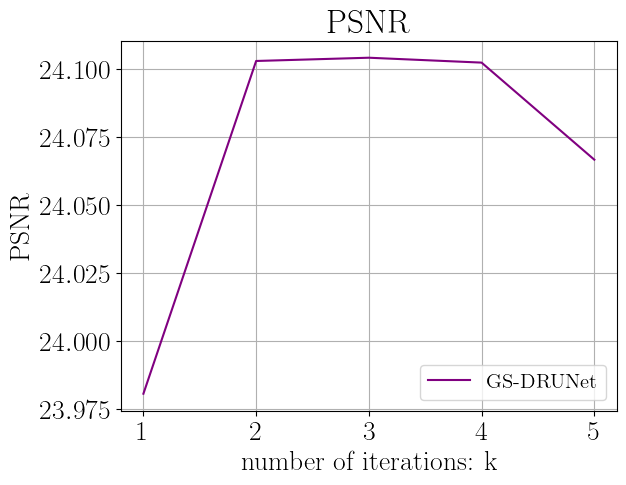

In [1255]:
comparison_plot(agsdrunetpsnr, 'GS-DRUNet', color='purple')
#comparison_plot(aproxpnsr, 'proximal', color='blue')

In [437]:
iters = 200
admm_gsdru, agsdrunetpsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = iters)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 200/200 [00:19<00:00, 10.16it/s]

Final PSNR: nan dB


In [887]:
admm_bm3d, abm3dpsnr, abm3diff, abm3dpairs, abm3dincr = pnp_admm(A, gauss_y, x, 'bm3d', niter = 200, beta = 10)


bm3d-PnP ADMM iterations:  96%|█████████▋| 193/200 [03:36<00:15,  2.20s/it]

bm3d-PnP ADMM iterations:  97%|█████████▋| 194/200 [03:37<00:11,  1.87s/it]

bm3d-PnP ADMM iterations:  98%|█████████▊| 195/200 [03:40<00:11,  2.24s/it]

bm3d-PnP ADMM iterations:  98%|█████████▊| 196/200 [03:41<00:07,  1.97s/it]

bm3d-PnP ADMM iterations:  98%|█████████▊| 197/200 [03:44<00:06,  2.09s/it]

bm3d-PnP ADMM iterations:  99%|█████████▉| 198/200 [03:45<00:03,  1.85s/it]

bm3d-PnP ADMM iterations: 100%|█████████▉| 199/200 [03:49<00:02,  2.35s/it]

bm3d-PnP ADMM iterations: 100%|██████████| 200/200 [03:50<00:00,  1.15s/it]

Final PSNR: 24.25 dB


In [1040]:
admm_tv, atvpsnr, atvdiff, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = iters, lamb= 1e-1, beta = 10)

tv-PnP ADMM iterations: 100%|██████████| 200/200 [00:04<00:00, 41.01it/s]

Final PSNR: 24.18 dB


In [1177]:
iters = 50
#admm_prox, aproxpsnr, aproxdiff, aproxpairs, aproxincr = pnp_admm(A, gauss_y, x, 'proximal', niter = iters, beta = 10, lamb = 1)
#admm_bm3d, abm3dpsnr, abm3diff, abm3dpairs = pnp_admm(A, gauss_y, x, 'bm3d', niter = iters)
admm_tv, atvpsnr, atvdiff, atvpairs, atvincr = pnp_admm(A, gauss_y, x, 'tv', niter = iters, lamb= 1e-3, beta = 10)
admm_dncnn, adncnnpsnr, acnndiff, adncnnpairs, adncnnincr  = pnp_admm(A, gauss_y, x, 'DnCNN', niter = iters, beta = 100)


tv-PnP ADMM iterations: 100%|██████████| 50/50 [00:00<00:00, 106.65it/s]


Final PSNR: 24.30 dB


DnCNN-PnP ADMM iterations: 100%|██████████| 50/50 [00:01<00:00, 40.55it/s]

Final PSNR: 24.11 dB


In [ ]:
admm_dru, adrunetpsnr, adrudiff, adrupairs, adruincr = pnp_admm(A, gauss_y, x, 'DRUNet', niter = iters, beta = 10)

In [1206]:
admm_gsdru, agspsnr, agsdrudiff, agsdrupairs, agsdruincr = pnp_admm(A, gauss_y, x, 'GS-DRUNet', niter = 2, beta = 1e+1)

GS-DRUNet-PnP ADMM iterations: 100%|██████████| 2/2 [00:00<00:00,  6.11it/s]

Final PSNR: 24.38 dB


In [1207]:
gslist = []
for i in agspsnr:
    gslist.append(i)

In [1208]:
for i in range(48):
    gslist.append(24.38)

In [1239]:
agsincr = []
total = 1
for i in cnnincr:
    agsincr.append(i*0.01)
    total += 1
    if total == 51:
        break

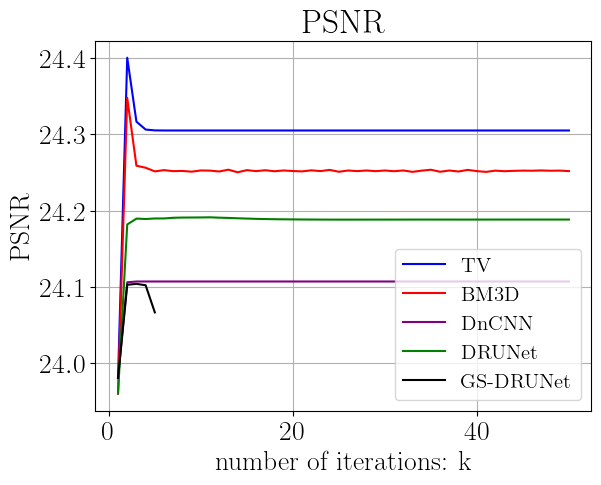

In [1184]:
#comparison_plot(aproxpsnr,'Proximal', color='orange')
comparison_plot(atvpsnr, 'TV', color='blue')
comparison_plot(abm3dpsnr[:50], 'BM3D', color='red')
comparison_plot(adncnnpsnr, 'DnCNN', color='purple')
comparison_plot(adrunetpsnr, 'DRUNet', color='green')
comparison_plot(agspsnr, 'GS-DRUNet', color='black')

<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\|'
<>:32: SyntaxWarning: invalid escape sequence '\s'
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\4196630640.py:17: SyntaxWarning: invalid escape sequence '\|'
  ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\4196630640.py:32: SyntaxWarning: invalid escape sequence '\s'
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
C:\Users\as5057\AppData\Local\Temp\ipykernel_3012\4196630640.py:32: RuntimeWarning: divide by zero encountered in divide
  ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)


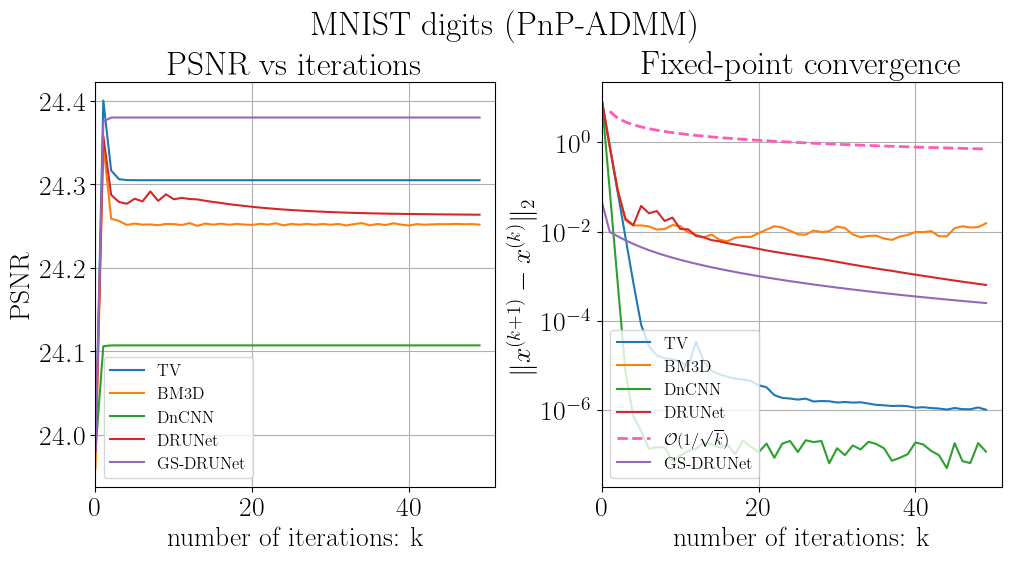

In [1246]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5.5), constrained_layout = True)
fig.suptitle('MNIST digits (PnP-ADMM)')
ax1.set_title('PSNR vs iterations')
ax2.set_title('Fixed-point convergence')
def plot_psnrs_differences(psnrs, diffs, method, color='blue'):
    """
    Peak-signal-to-noise ratio (PSNR) and residual plots vs iterations for a prior denoiser
    """

    #fig.suptitle(method)
    ax1.plot(range(0, len(psnrs)), psnrs, label = method)
    ax1.set_ylabel('PSNR')
    ax1.set_xlabel('number of iterations: k')
    ax1.grid(True)

    ax2.semilogy(range(0, len(diffs)),diffs, label = method)
    ax2.set_ylabel('$\\|x^{(k+1)} - x^{(k)}\|_2$')
    ax2.set_xlabel('number of iterations: k')
    ax2.grid(True)
    ax1.set_xlim([0, 51])
    ax2.set_xlim([0, 51])
    return psnrs[-1]

#proxpsnr = plot_psnrs_differences(aproxpsnr, aproxincr, 'Prox')
tvpsnr = plot_psnrs_differences(atvpsnr, atvincr, 'TV')
bm3dpsnr = plot_psnrs_differences(abm3dpsnr[:50], abm3dincr[:50], 'BM3D')
dncnnpsnr = plot_psnrs_differences(adncnnpsnr, adncnnincr, 'DnCNN')
drunetpsnr = plot_psnrs_differences(adrunetpsnr, adruincr, 'DRUNet')
iterations = np.arange(50)

#ax2.semilogy(iterations, 80/iterations, label = '$\\mathcal{O}(1/k)$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
ax2.semilogy(iterations, 5/(iterations**0.5), label = '$\\mathcal{O}(1/\sqrt{k})$', linestyle = '--', color = '#FF5AB7', linewidth = 2)
gspsnr = plot_psnrs_differences(gslist, agsincr, 'GS-DRUNet')
apsnrs_list = [21.89, tvpsnr, bm3dpsnr, dncnnpsnr, drunetpsnr, gspsnr]

ax1.legend(fontsize = 12, loc = 'best')
ax2.legend(fontsize = 12, loc = 'best')
plt.savefig('plots/PnPADMMMNISTGraphs.png', dpi = 300)

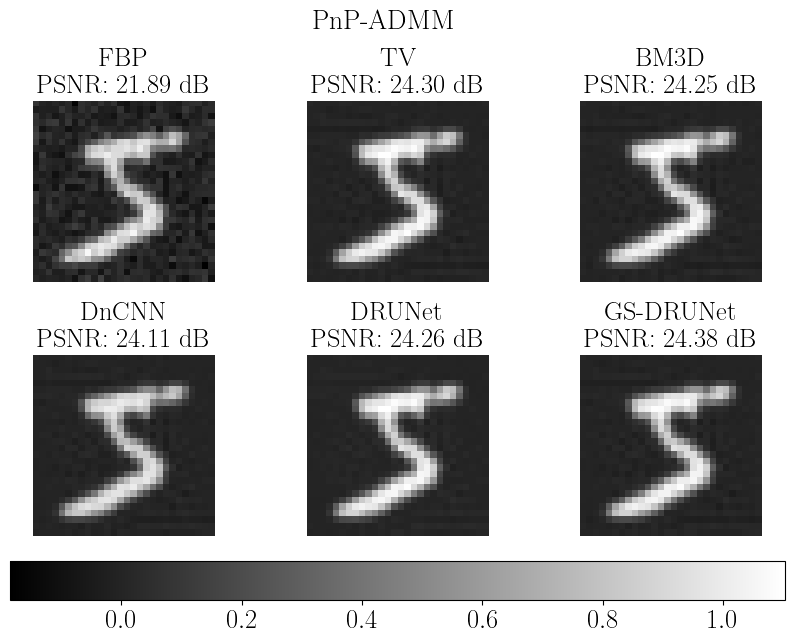

In [1247]:
plotting_estimates1(gfbp.reshape(imsize), admm_tv.reshape(imsize), admm_bm3d.reshape(imsize), admm_dncnn.reshape(imsize), admm_dru.reshape(imsize), admm_gsdru.reshape(imsize), apsnrs_list, title = 'PnP-ADMM')